Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet18-mnist.ipynb)

## Code Modules, Classes, & Functions

[GoogleColaboratory Variant](https://colab.research.google.com/drive/1OBmekkzdgivSLrJq_6HTtHZKc5ZNXbqX)

In [1]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch
from torchvision.datasets import MNIST as tmnist
from torchvision import transforms
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
from torch.utils.data.dataset import Subset
import tensorflow.image as timage
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [2]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [3]:
def display_examples(data_loader,img_size):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(11,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size),
                      cmap=pl.cm.bone)
        break

In [4]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader,valid_loader,test_loader]
    if int(n)==2:
        data_loader=\
        [train_loader2,valid_loader2,test_loader2]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))

## Data

In [5]:
random_seed=12; batch_size=128
tr0=(.5); tr1=(.25); img_size=28
trans=transforms\
.Compose([transforms.Resize((img_size,img_size)),
          transforms.ToTensor(),
          transforms.Normalize(tr0,tr1)])
train_ids=torch.arange(0,54000)
valid_ids=torch.arange(54000,60000)
train_valid=tmnist(root='data',train=True,
                   download=True,transform=trans)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tmnist(root='data',train=False, 
            transform=trans)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
valid_loader=tdl(dataset=valid,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Image dimensions: torch.Size([128, 1, 28, 28])
Label dimensions: torch.Size([128])



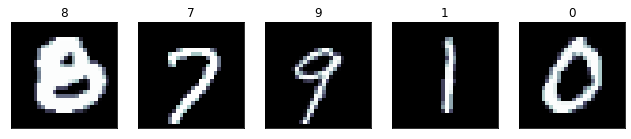

In [6]:
display_examples(valid_loader,img_size)

In [7]:
fpath='../input/classification-of-handwritten-letters/'
f='LetterColorImages_123.h5'
f=h5py.File(fpath+f,'r')
keys=list(f.keys()); print(keys)
x=1-np.array(f[keys[1]],dtype='float32')/255
x=timage.resize(x,[img_size,img_size])
x=(np.dot(x.numpy(),[.299,.587,.114]))\
.reshape(-1,1,img_size,img_size)
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
random_seed=23; batch_size2=128
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,shuffle=True,
                  batch_size=batch_size2)
valid_loader2=tdl(dataset=valid2,shuffle=True,
                  batch_size=batch_size2)
test_loader2=tdl(dataset=test2,shuffle=False,
                 batch_size=batch_size2)

['backgrounds', 'images', 'labels']


Image dimensions: torch.Size([128, 1, 28, 28])
Label dimensions: torch.Size([128])


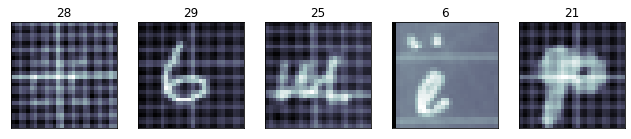

In [8]:
display_examples(valid_loader2,img_size)

## ResNet

In [9]:
def conv3x3(in_planes,out_planes,stride=1):
    return tnn.Conv2d(in_planes,out_planes,
                      kernel_size=3,stride=stride,
                      padding=1,bias=False)
class BasicBlock(tnn.Module):
    expansion=1
    def __init__(self,inplanes,planes,
                 stride=1,downsample=None):
        super(BasicBlock,self).__init__()
        self.conv1=conv3x3(inplanes,planes,stride)
        self.bn1=tnn.BatchNorm2d(planes)
        self.relu=tnn.ReLU(inplace=True)
        self.conv2=conv3x3(planes,planes)
        self.bn2=tnn.BatchNorm2d(planes)
        self.downsample=downsample
        self.stride=stride
    def forward(self,x):
        residual=x
        y=self.conv1(x); y=self.bn1(y)
        y=self.relu(y)
        y=self.conv2(y); y=self.bn2(y)
        if self.downsample is not None:
            residual=self.downsample(x)
        y+=residual
        y=self.relu(y)
        return y

In [10]:
class ResNet(tnn.Module):
    def __init__(self,block,layers,num_classes,grayscale):
        self.inplanes=64
        if grayscale: in_dim=1
        else: in_dim=3
        super(ResNet,self).__init__()
        self.conv1=tnn\
        .Conv2d(in_dim,64,kernel_size=7,stride=2,
                padding=3,bias=False)
        self.bn1=tnn.BatchNorm2d(64)
        self.relu=tnn.ReLU(inplace=True)
        self.maxpool=tnn\
        .MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.layer1=self._make_layer(block,64,layers[0])
        self.layer2=self._make_layer(block,128,
                                     layers[1],stride=2)
        self.layer3=self._make_layer(block,256,
                                     layers[2],stride=2)
        self.layer4=self._make_layer(block,512,
                                     layers[3],stride=2)
        self.avgpool=tnn.AvgPool2d(7,stride=1)
        self.fc=tnn.Linear(512*block.expansion,num_classes)
        for m in self.modules():
            if isinstance(m,tnn.Conv2d):
                n=m.kernel_size[0]*m.kernel_size[1]*m.out_channels
                m.weight.data.normal_(0,(2./n)**.5)
            elif isinstance(m,tnn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def _make_layer(self,block,planes,blocks,stride=1):
        downsample=None
        if stride!=1 or self.inplanes!=planes*block.expansion:
            downsample=tnn.Sequential(
                tnn.Conv2d(self.inplanes,planes*block.expansion,
                           kernel_size=1,stride=stride,bias=False),
                tnn.BatchNorm2d(planes*block.expansion))
        layers=[]
        layers.append(block(self.inplanes,planes,
                            stride,downsample))
        self.inplanes=planes*block.expansion
        for i in range(1,blocks):
            layers.append(block(self.inplanes,planes))
        return tnn.Sequential(*layers)
    def forward(self,x):
        x=self.conv1(x); x=self.bn1(x)
        x=self.relu(x); x=self.maxpool(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
#        x=self.avgpool(x)        
        x=x.view(x.size(0),-1)
        logits=self.fc(x)
        probs=tnnf.softmax(logits,dim=1)
        return logits,probs
def ResNN(num_classes):
    model=ResNet(block=BasicBlock,layers=[2,2,2,2],
                num_classes=num_classes,
                grayscale=True)
    return model

## Training

In [11]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%200:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader),
                   model_acc(model,valid_loader)))

In [12]:
torch.manual_seed(random_seed)
num_classes=10; learning_rate=.001
model=ResNN(num_classes)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [13]:
%train_run 55

Epoch: 001/055 | Batch 000/421 | Cost: 2.5748
Epoch: 001/055 | Batch 200/421 | Cost: 0.0465
Epoch: 001/055 | Batch 400/421 | Cost: 0.1487
Epoch: 001/055 train acc: 98.09% valid acc: 97.98%
Epoch: 002/055 | Batch 000/421 | Cost: 0.0298
Epoch: 002/055 | Batch 200/421 | Cost: 0.0889
Epoch: 002/055 | Batch 400/421 | Cost: 0.0950
Epoch: 002/055 train acc: 98.70% valid acc: 98.65%
Epoch: 003/055 | Batch 000/421 | Cost: 0.0296
Epoch: 003/055 | Batch 200/421 | Cost: 0.0279
Epoch: 003/055 | Batch 400/421 | Cost: 0.0319
Epoch: 003/055 train acc: 99.11% valid acc: 98.58%
Epoch: 004/055 | Batch 000/421 | Cost: 0.0074
Epoch: 004/055 | Batch 200/421 | Cost: 0.0552
Epoch: 004/055 | Batch 400/421 | Cost: 0.0239
Epoch: 004/055 train acc: 99.16% valid acc: 98.82%
Epoch: 005/055 | Batch 000/421 | Cost: 0.0030
Epoch: 005/055 | Batch 200/421 | Cost: 0.0806
Epoch: 005/055 | Batch 400/421 | Cost: 0.0133
Epoch: 005/055 train acc: 99.40% valid acc: 98.95%
Epoch: 006/055 | Batch 000/421 | Cost: 0.0052
Epoch: 00

In [14]:
%print_acc 1

Train accuracy: 99.9167%
Valid accuracy: 99.2000%
Test accuracy: 99.3400%


In [15]:
@register_line_magic
def train_run2(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader2):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets.long())
            optimizer2.zero_grad(); cost.backward()
            optimizer2.step()
            if not batch_ids%50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train2)//batch_size2,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader2),
                   model_acc(model,valid_loader2)))

In [16]:
torch.manual_seed(random_seed)
num_classes=33; learning_rate=.001
model=ResNN(num_classes)
model.to(dev)
optimizer2=torch.optim.Adam(model.parameters(),
                            lr=learning_rate)

In [17]:
%train_run2 50

Epoch: 001/050 | Batch 000/088 | Cost: 3.6754
Epoch: 001/050 | Batch 050/088 | Cost: 2.2928
Epoch: 001/050 train acc: 28.47% valid acc: 27.27%
Epoch: 002/050 | Batch 000/088 | Cost: 1.5762
Epoch: 002/050 | Batch 050/088 | Cost: 0.9819
Epoch: 002/050 train acc: 43.67% valid acc: 41.86%
Epoch: 003/050 | Batch 000/088 | Cost: 1.0811
Epoch: 003/050 | Batch 050/088 | Cost: 0.8584
Epoch: 003/050 train acc: 64.77% valid acc: 60.96%
Epoch: 004/050 | Batch 000/088 | Cost: 0.5523
Epoch: 004/050 | Batch 050/088 | Cost: 0.5115
Epoch: 004/050 train acc: 72.57% valid acc: 67.65%
Epoch: 005/050 | Batch 000/088 | Cost: 0.4439
Epoch: 005/050 | Batch 050/088 | Cost: 0.4421
Epoch: 005/050 train acc: 77.95% valid acc: 72.73%
Epoch: 006/050 | Batch 000/088 | Cost: 0.4814
Epoch: 006/050 | Batch 050/088 | Cost: 0.4961
Epoch: 006/050 train acc: 70.09% valid acc: 64.41%
Epoch: 007/050 | Batch 000/088 | Cost: 0.4459
Epoch: 007/050 | Batch 050/088 | Cost: 0.2604
Epoch: 007/050 train acc: 85.55% valid acc: 76.25%

In [18]:
%print_acc 2

Train accuracy: 95.0141%
Valid accuracy: 83.7914%
Test accuracy: 84.5666%
